In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn import metrics
import gc
from sklearn.metrics import  mean_absolute_error
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
##### READ IN RAW DATA
prop = pd.read_csv('Data/properties_2016.csv', low_memory=False)
train = pd.read_csv("Data/train_2016_v2.csv")

In [21]:
target = "logerror"

In [22]:
train.shape

(90275, 3)

In [23]:
train.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [24]:
prop.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [25]:
##### PROCESS DATA FOR LIGHTGBM
for c, dtype in zip(prop.columns, prop.dtypes):	
    if dtype == np.float64:		
        prop[c] = prop[c].astype(np.float32)

In [55]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=False, cv_folds=5, early_stopping_rounds=50, categorical_feature=None):
    
    if useTrainCV:
        lgb_param = alg.get_params()
        print(lgb_param)
        train_set = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values)
#         xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
#         xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = lgb.cv(params, xgtrain, num_boost_round=10, nfold=cv_folds,
            metrics='mae', early_stopping_rounds=early_stopping_rounds, show_stdv=False)
        print(cvresult)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
#    alg.fit(dtrain[predictors], dtrain[target],eval_metric='mae', categorical_feature=categorical_feature,
#            verbose=5)
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='mae', verbose=5)
        
        #Print model report:
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
#    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    print("\nModel Report")
    print('The mae of prediction (Training) is:', mean_absolute_error(dtrain[target].values, dtrain_predictions))

    
#    Predict on testing data:
    dtest_predictions = alg.predict(dtest[predictors])        
    print('The mae of prediction (Testing) is:', mean_absolute_error(dtest[target].values, dtest_predictions))
    
    print('Plot feature importances...')
    ax = lgb.plot_importance(alg, max_num_features=40, figsize=(16,20))

In [27]:
# Split data to training and testing sets
#housing = train.merge(prop, how='left', on='parcelid')
train_set, test_set = train_test_split(train, test_size=0.2, random_state=42)

In [28]:
train_set.shape

(72220, 3)

In [36]:
# Identify categorical data
cat_columns = prop.dtypes[prop.dtypes == object].index.values
print(cat_columns)
num_columns = prop.dtypes[prop.dtypes == np.float32].index.values

['hashottuborspa' 'propertycountylandusecode' 'propertyzoningdesc'
 'fireplaceflag' 'taxdelinquencyflag']


In [37]:
prop_new = prop.fillna(prop.median(numeric_only=True), inplace=False)

In [39]:
for col in cat_columns:
    prop_new[col], train_categories = prop_new[col].factorize()

In [40]:
df_train = train_set.merge(prop_new, how='left', on='parcelid')
df_test = test_set.merge(prop_new, how='left', on='parcelid')

In [41]:
df_train.shape, df_test.shape

((72220, 60), (18055, 60))

In [42]:
x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate'], axis=1)
y_train = df_train['logerror'].values
print(x_train.shape, y_train.shape)

(72220, 57) (72220,)


In [43]:
x_test = df_test.drop(['parcelid', 'logerror', 'transactiondate'], axis=1)
y_test = df_test[target].values

In [44]:
#x_train = x_train.values.astype(np.float32, copy=False)
d_train = lgb.Dataset(x_train, label=y_train)
d_eval = lgb.Dataset(x_test, y_test, reference=d_train)

In [53]:
cat_columns_list = sorted(cat_columns.tolist())
cat_columns_list

['fireplaceflag',
 'hashottuborspa',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'taxdelinquencyflag']

In [48]:
format(sorted(cat_columns_list))

"['fireplaceflag', 'hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'taxdelinquencyflag']"


Model Report
The mae of prediction (Training) is: 0.0683575606402
The mae of prediction (Testing) is: 0.0686544063199
Plot feature importances...


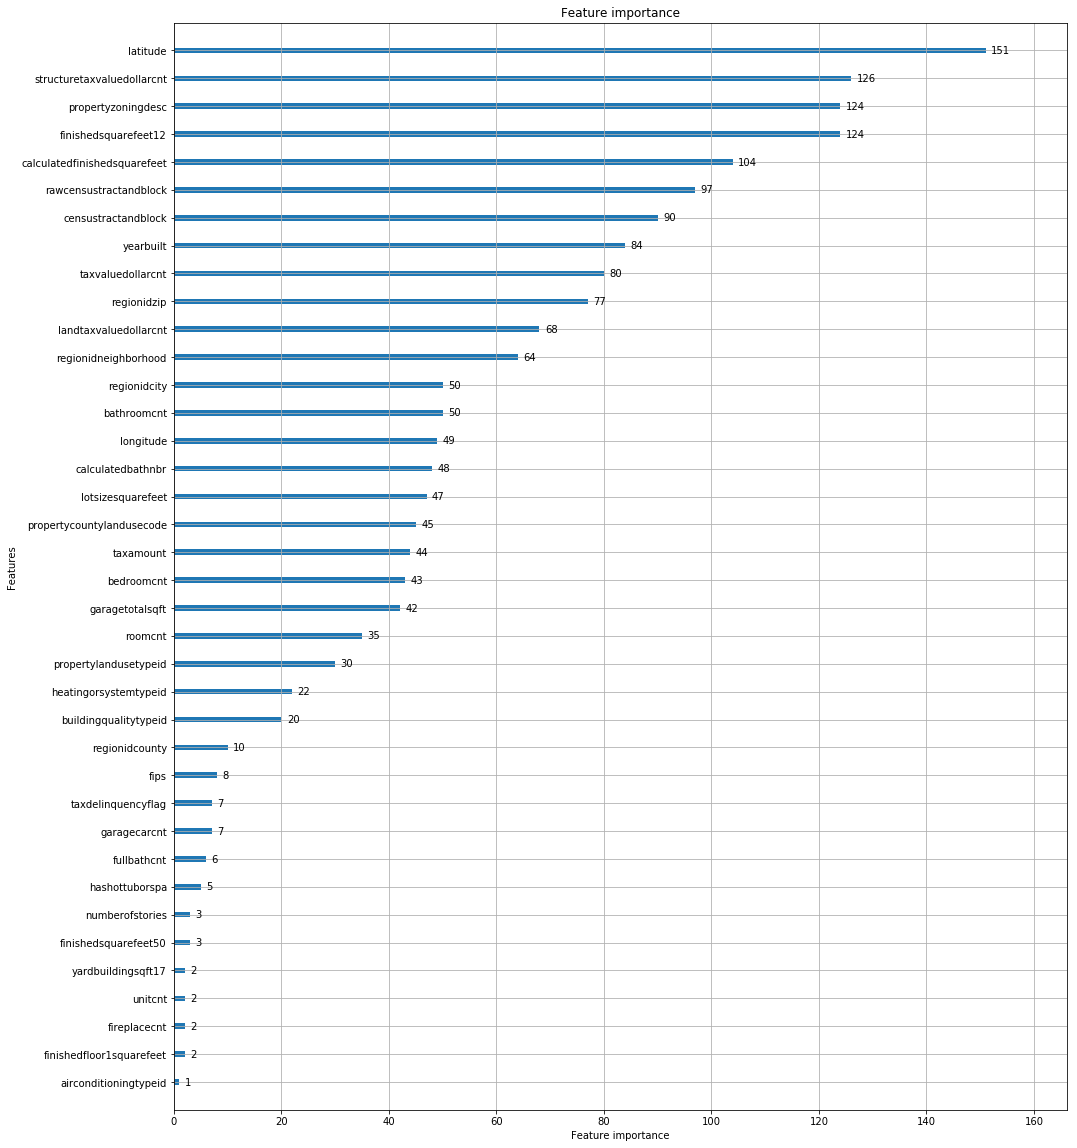

In [56]:
predictors = [x for x in df_train.columns if x not in ['parcelid', 'logerror', 'transactiondate']]
lgb1 = lgb.LGBMRegressor(objective='regresion',
                        max_bin=10,
                        num_leaves=512,
                        learning_rate=0.0021,
                        n_estimators=20,
                        subsample=0.85,
                        subsample_freq = 40,
                        sub_feature=0.4,
                        min_data=500,
                        min_hessian=0.05,
                        random_state=42)
modelfit(lgb1, df_train, df_test, predictors, categorical_feature=cat_columns_list)

In [57]:
param_test1 = {'n_estimators' : range(600,801,20)}
estim = lgb.LGBMRegressor(objective='regresion',
                        max_bin=10,
                        num_leaves=512,
                        learning_rate=0.0021,
                        n_estimators=20,
                        subsample=0.85,
                        subsample_freq = 40,
                        sub_feature=0.4,
                        min_data=500,
                        min_hessian=0.05,
                        random_state=42)
lsearch1 = GridSearchCV(estimator=estim, param_grid=param_test1, scoring='neg_mean_absolute_error', iid=False,
                       cv=5)
lsearch1.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', colsample_bytree=1.0,
       learning_rate=0.0021, max_bin=10, max_depth=-1,
       min_child_samples=10, min_child_weight=5, min_data=500,
       min_hessian=0.05, min_split_gain=0.0, n_estimators=20, n_jobs=-1,
       num_leaves=512, objective='regresion', random_state=42,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, sub_feature=0.4,
       subsample=0.85, subsample_for_bin=50000, subsample_freq=40),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'n_estimators': range(600, 801, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [58]:
lsearch1.grid_scores_, lsearch1.best_params_, lsearch1.best_score_

/home/jaromir/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.06798, std: 0.00107, params: {'n_estimators': 600},
  mean: -0.06798, std: 0.00107, params: {'n_estimators': 620},
  mean: -0.06798, std: 0.00107, params: {'n_estimators': 640},
  mean: -0.06798, std: 0.00107, params: {'n_estimators': 660},
  mean: -0.06798, std: 0.00107, params: {'n_estimators': 680},
  mean: -0.06798, std: 0.00107, params: {'n_estimators': 700},
  mean: -0.06798, std: 0.00107, params: {'n_estimators': 720},
  mean: -0.06798, std: 0.00107, params: {'n_estimators': 740},
  mean: -0.06798, std: 0.00106, params: {'n_estimators': 760},
  mean: -0.06798, std: 0.00106, params: {'n_estimators': 780},
  mean: -0.06798, std: 0.00106, params: {'n_estimators': 800}],
 {'n_estimators': 640},
 -0.067977160576458362)

In [61]:
param_test2 = {'max_depth' : range(5,16,2), 'min_data_in_leaf' : range(100,1001,100)}
estim2 = lgb.LGBMRegressor(objective='regresion',
                        max_bin=10,
                        num_leaves=512,
                        learning_rate=0.0021,
                        n_estimators=640,
                        subsample=0.85,
                        subsample_freq = 40,
                        sub_feature=0.4,
                        min_data_in_leaf=500,
                        min_hessian=0.05,
                        random_state=42)
lsearch2 = GridSearchCV(estimator=estim2, param_grid=param_test2, scoring='neg_mean_absolute_error', iid=False,
                       cv=5)
lsearch2.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', colsample_bytree=1.0,
       learning_rate=0.0021, max_bin=10, max_depth=-1,
       min_child_samples=10, min_child_weight=5, min_data_in_leaf=500,
       min_hessian=0.05, min_split_gain=0.0, n_estimators=640, n_jobs=-1,
       num_leaves=512, objective='regresion', random_state=42,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, sub_feature=0.4,
       subsample=0.85, subsample_for_bin=50000, subsample_freq=40),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'max_depth': range(5, 16, 2), 'min_data_in_leaf': range(100, 1001, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [62]:
lsearch2.grid_scores_, lsearch2.best_params_, lsearch2.best_score_

/home/jaromir/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.06800, std: 0.00105, params: {'max_depth': 5, 'min_data_in_leaf': 100},
  mean: -0.06800, std: 0.00105, params: {'max_depth': 5, 'min_data_in_leaf': 200},
  mean: -0.06801, std: 0.00105, params: {'max_depth': 5, 'min_data_in_leaf': 300},
  mean: -0.06802, std: 0.00105, params: {'max_depth': 5, 'min_data_in_leaf': 400},
  mean: -0.06802, std: 0.00105, params: {'max_depth': 5, 'min_data_in_leaf': 500},
  mean: -0.06803, std: 0.00105, params: {'max_depth': 5, 'min_data_in_leaf': 600},
  mean: -0.06803, std: 0.00105, params: {'max_depth': 5, 'min_data_in_leaf': 700},
  mean: -0.06804, std: 0.00105, params: {'max_depth': 5, 'min_data_in_leaf': 800},
  mean: -0.06805, std: 0.00105, params: {'max_depth': 5, 'min_data_in_leaf': 900},
  mean: -0.06806, std: 0.00105, params: {'max_depth': 5, 'min_data_in_leaf': 1000},
  mean: -0.06794, std: 0.00105, params: {'max_depth': 7, 'min_data_in_leaf': 100},
  mean: -0.06795, std: 0.00106, params: {'max_depth': 7, 'min_data_in_leaf': 200},
  m

In [63]:
param_test3 = {'min_data_in_leaf' : range(10,151,10)}
estim3 = lgb.LGBMRegressor(objective='regresion',
                        max_bin=255,
                        num_leaves=512,
                        learning_rate=0.0021,
                        n_estimators=640,
                        subsample=0.85,
                        subsample_freq = 40,
                        sub_feature=0.4,
                        min_hessian=0.05,
                        random_state=42)
lsearch3 = GridSearchCV(estimator=estim3, param_grid=param_test3, scoring='neg_mean_absolute_error', iid=False,
                       cv=5)
lsearch3.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', colsample_bytree=1.0,
       learning_rate=0.0021, max_bin=255, max_depth=-1,
       min_child_samples=10, min_child_weight=5, min_hessian=0.05,
       min_split_gain=0.0, n_estimators=640, n_jobs=-1, num_leaves=512,
       objective='regresion', random_state=42, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, sub_feature=0.4, subsample=0.85,
       subsample_for_bin=50000, subsample_freq=40),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'min_data_in_leaf': range(10, 151, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [64]:
lsearch3.grid_scores_, lsearch3.best_params_, lsearch3.best_score_

/home/jaromir/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.06830, std: 0.00112, params: {'min_data_in_leaf': 10},
  mean: -0.06822, std: 0.00111, params: {'min_data_in_leaf': 20},
  mean: -0.06815, std: 0.00111, params: {'min_data_in_leaf': 30},
  mean: -0.06809, std: 0.00112, params: {'min_data_in_leaf': 40},
  mean: -0.06806, std: 0.00112, params: {'min_data_in_leaf': 50},
  mean: -0.06802, std: 0.00111, params: {'min_data_in_leaf': 60},
  mean: -0.06799, std: 0.00111, params: {'min_data_in_leaf': 70},
  mean: -0.06796, std: 0.00111, params: {'min_data_in_leaf': 80},
  mean: -0.06795, std: 0.00111, params: {'min_data_in_leaf': 90},
  mean: -0.06795, std: 0.00110, params: {'min_data_in_leaf': 100},
  mean: -0.06794, std: 0.00110, params: {'min_data_in_leaf': 110},
  mean: -0.06794, std: 0.00109, params: {'min_data_in_leaf': 120},
  mean: -0.06794, std: 0.00109, params: {'min_data_in_leaf': 130},
  mean: -0.06794, std: 0.00109, params: {'min_data_in_leaf': 140},
  mean: -0.06793, std: 0.00109, params: {'min_data_in_leaf': 150}],
 {'


Model Report
The mae of prediction (Training) is: 0.0662531508708
The mae of prediction (Testing) is: 0.0680585309822
Plot feature importances...


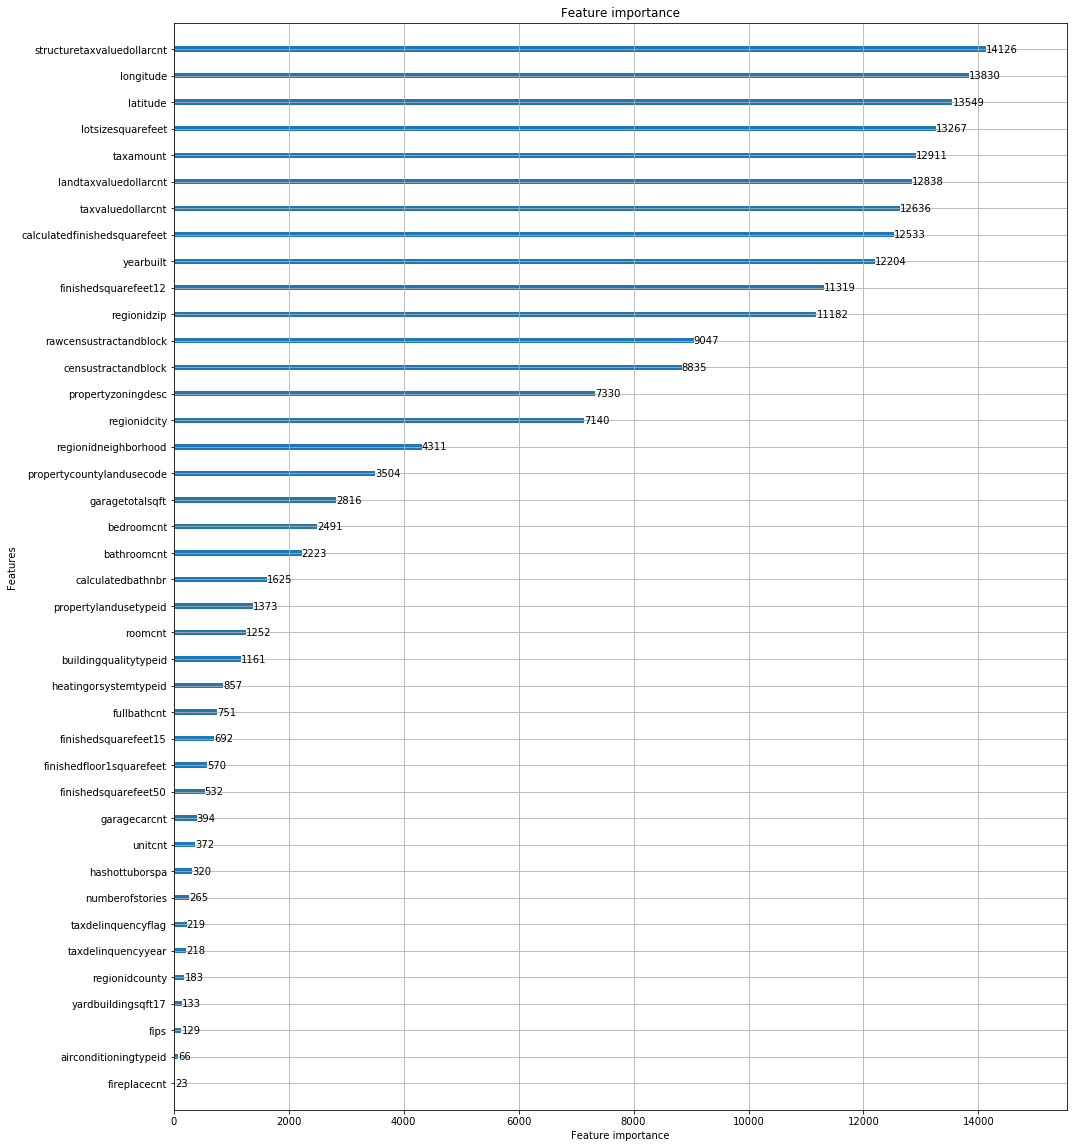

In [65]:
predictors = [x for x in df_train.columns if x not in ['parcelid', 'logerror', 'transactiondate']]
lgb1 = lgb.LGBMRegressor(objective='regresion',
                        max_bin=255,
                        num_leaves=512,
                        learning_rate=0.0021,
                        n_estimators=640,
                        subsample=0.85,
                        subsample_freq = 40,
                        sub_feature=0.4,
                        min_data=150,
                        min_hessian=0.05,
                        random_state=42)
modelfit(lgb1, df_train, df_test, predictors, categorical_feature=cat_columns_list)

In [34]:
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.0021 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.5      # feature_fraction -- OK, back to .5, but maybe later increase this
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 10

In [35]:
evals_result = {}

In [36]:
print("\nFitting LightGBM model ...")
clf = lgb.train(params, d_train, 430, categorical_feature=cat_columns_list, valid_sets=d_eval, 
                early_stopping_rounds=5, evals_result=evals_result)



Fitting LightGBM model ...
[1]	valid_0's l1: 0.0686925
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.068688
[3]	valid_0's l1: 0.0686859
[4]	valid_0's l1: 0.0686821
[5]	valid_0's l1: 0.0686781
[6]	valid_0's l1: 0.0686746
[7]	valid_0's l1: 0.068671
[8]	valid_0's l1: 0.0686669
[9]	valid_0's l1: 0.0686641
[10]	valid_0's l1: 0.0686625
[11]	valid_0's l1: 0.0686595
[12]	valid_0's l1: 0.0686572
[13]	valid_0's l1: 0.0686542
[14]	valid_0's l1: 0.0686522
[15]	valid_0's l1: 0.0686482
[16]	valid_0's l1: 0.0686445
[17]	valid_0's l1: 0.0686418
[18]	valid_0's l1: 0.068639
[19]	valid_0's l1: 0.0686362
[20]	valid_0's l1: 0.0686335
[21]	valid_0's l1: 0.0686326
[22]	valid_0's l1: 0.0686298
[23]	valid_0's l1: 0.0686257
[24]	valid_0's l1: 0.0686224
[25]	valid_0's l1: 0.0686195
[26]	valid_0's l1: 0.0686161
[27]	valid_0's l1: 0.0686134
[28]	valid_0's l1: 0.0686108
[29]	valid_0's l1: 0.0686087
[30]	valid_0's l1: 0.0686053
[31]	valid_0's l1: 0.0686033
[32]	valid_0's l1: 0.068

Plot feature importances...


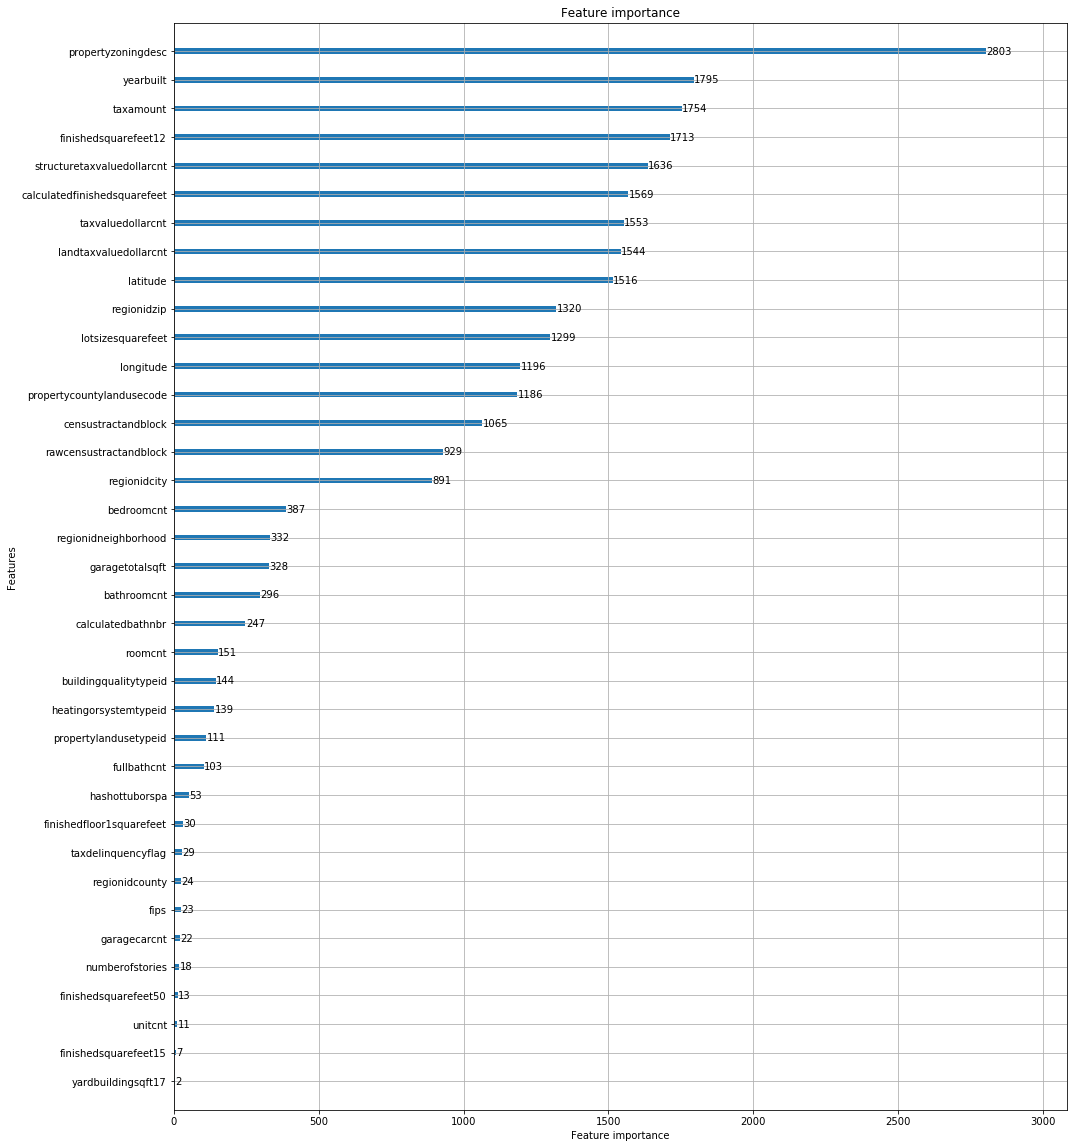

In [81]:
print('Plot feature importances...')
ax = lgb.plot_importance(clf, max_num_features=40, figsize=(16,20))

Plot metrics during training...


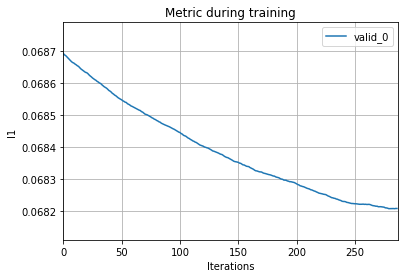

In [38]:
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='l1')

In [41]:
print('Start predicting...')
# predict
y_pred = clf.predict(x_test, num_iteration=clf.best_iteration)
# eval
print('The mae of prediction is:', mean_absolute_error(y_test, y_pred))


Start predicting...
The mae of prediction is: 0.0682084962369


In [46]:
#train
estimator = lgb.LGBMRegressor(objective='regresion',
                       num_leaves=31,
                       learning_rate=0.05,
                       n_estimators=20)

In [47]:
estimator.fit(x_train, y_train,
       eval_set=[(x_test, y_test)],
       eval_metric='l1',
       early_stopping_rounds=5)

[1]	valid_0's l1: 0.0686427
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0685838
[3]	valid_0's l1: 0.0685385
[4]	valid_0's l1: 0.0684965
[5]	valid_0's l1: 0.0684672
[6]	valid_0's l1: 0.0684367
[7]	valid_0's l1: 0.0684018
[8]	valid_0's l1: 0.0683704
[9]	valid_0's l1: 0.0683416
[10]	valid_0's l1: 0.0683307
[11]	valid_0's l1: 0.068308
[12]	valid_0's l1: 0.0682853
[13]	valid_0's l1: 0.0682681
[14]	valid_0's l1: 0.0682575
[15]	valid_0's l1: 0.0682573
[16]	valid_0's l1: 0.0682489
[17]	valid_0's l1: 0.0682492
[18]	valid_0's l1: 0.0682423
[19]	valid_0's l1: 0.0682313
[20]	valid_0's l1: 0.0682307


LGBMRegressor(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.05,
       max_bin=255, max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=31,
       objective='regresion', random_state=0, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0, subsample_for_bin=50000,
       subsample_freq=1)

In [48]:
#predict
y_pred = estimator.predict(x_test, num_iteration=gbm.best_iteration_)

In [49]:
#eval
print('The mae of prediction is:', mean_absolute_error(y_test, y_pred))

The mae of prediction is: 0.068230741933


In [69]:
param_grid = {
    'learning_rate' : [0.01, 0.05, 0.1, 1],
    'n_estimators' : [20, 40, 80, 160]
}

In [77]:
gbm = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=10, refit=True)

In [78]:
gbm.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.05,
       max_bin=255, max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=31,
       objective='regresion', random_state=0, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0, subsample_for_bin=50000,
       subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.05, 0.1, 1], 'n_estimators': [20, 40, 80, 160]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [79]:
print('Best parameter found by grid search are:', gbm.best_params_)

Best parameter found by grid search are: {'learning_rate': 0.01, 'n_estimators': 80}


In [93]:
estim = gbm.best_estimator_

In [94]:
estim.get_params()

{'boosting_type': 'gbdt',
 'colsample_bytree': 1.0,
 'learning_rate': 0.01,
 'max_bin': 255,
 'max_depth': -1,
 'min_child_samples': 10,
 'min_child_weight': 5,
 'min_split_gain': 0.0,
 'n_estimators': 80,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'regresion',
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 50000,
 'subsample_freq': 1}

In [76]:
gbm.cv_results_, gbm.best_params_, gbm.best_score_

/home/jaromir/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/jaromir/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/jaromir/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/jaromir/anaconda3/lib/py

({'mean_fit_time': array([ 0.16740878,  0.21645162,  0.31731064,  0.50894341,  0.22729821,
          0.32272103,  0.31440735,  0.46989446,  0.15708385,  0.20283515,
          0.28521187,  0.44021647,  0.1553427 ,  0.19147551,  0.26517889,
          0.52902663]),
  'mean_score_time': array([ 0.00475526,  0.00552356,  0.00753269,  0.01635056,  0.00495479,
          0.00567112,  0.0073225 ,  0.01446824,  0.00460014,  0.00502949,
          0.00739462,  0.01330571,  0.0046648 ,  0.00493691,  0.00636406,
          0.01076937]),
  'mean_test_score': array([-0.06823253, -0.06815155, -0.06812238, -0.06821295, -0.06814599,
         -0.06829653, -0.06854346, -0.0690038 , -0.06833832, -0.06865256,
         -0.06918195, -0.07001006, -0.07609119, -0.08082874, -0.0881216 ,
         -0.0975243 ]),
  'mean_train_score': array([-0.06814262, -0.06796422, -0.06774994, -0.06748037, -0.06768115,
         -0.06739434, -0.06691049, -0.06611664, -0.06742876, -0.06698398,
         -0.06621834, -0.06490332, -0.0